# Create multliayer products 

In [1]:
import pandas as pd
import numpy as np
import time
import networkx as nx
import geopandas as gpd # pip installed
import matplotlib.pyplot as plt 

In [2]:

def Node_strength_w(data):
    """ Calculate the node relevance in each layer of the multilayer network. 
    In a weighted directed network the country strenght is the sum of the magnitude exported by that country in that layer.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing trade data for a single year. The dataframe must contain 
    the columns: 'item', 'unit', 'origin_country_ISO', and 'value'.

    Returns:
    pd.DataFrame: DataFrame with country strength for each combination of 'item' and 'unit', sorted from highest to lowest. 
    Columns include 'item', 'unit', 'origin_country_ISO', and the calculated 'value' for node strength.

    Example:
    >>> df_result = Node_strength_w(input_data)
    """

    str_i_l = data.groupby(['item','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].
                                                        pivot_table(index='origin_country_ISO', aggfunc='sum').
                                                        sort_values(by = 'value',ascending=False))
    # Reset multi-index:
    strength_i_l= str_i_l.reset_index(level=['item','unit','origin_country_ISO']).rename(columns={'value':'str_i_l'})

    return strength_i_l
    
def Participation_coeff (data):

    #Define elements for part_coeff
    L = len(data.item.unique())

    o_i = Edge_overlap_w(data)

    s_i_l = Node_strength_w(data)

    # Prepare data
    data_for_Pc = pd.merge(s_i_l, o_i, left_on= 'origin_country_ISO',right_index=True, how='left')


    # Contibution of each layer to total exports
    data_for_Pc['sum_layers'] = (data_for_Pc['str_i_l']/data_for_Pc['o_i'])**2
    
    sum_layers= data_for_Pc.groupby(['origin_country_ISO']).apply(lambda group: group.sum_layers.sum())

    particip_coeff =  pd.DataFrame((L/(L-1))*(1- sum_layers),columns=['partic_coeff']).sort_values(by='partic_coeff',ascending=False)
    return particip_coeff 

In [75]:
year_check='2019-2021'
data = pd.read_pickle('../Data/Data_year_groups_12.pkl')
data = data.loc[(data.unit =='1000 US$') & (data.year == year_check) & (data.value > 0) ,:]

country_metadata = pd.read_pickle('../Data/Country_info.pkl')

Create single layer network with the total trade and find its degree distribution. 

In [109]:

def Agregated_network (edge_data,node_info):

    # General network 
    pos_dict = node_info.loc[:,['ISO','pos','name']].set_index('ISO').to_dict(orient='index')
    pos_dict

    edge_dict =dict(zip(zip(edge_data['origin_country_ISO'], edge_data['destin_country_ISO'], edge_data['item']), data['value']))
    edge_dict

    # Create network
    G=nx.MultiDiGraph()

    G.add_nodes_from(pos_dict)
    nx.set_node_attributes(G,pos_dict)

    G.add_edges_from(edge_dict.keys())
    nx.set_edge_attributes(G, edge_dict, 'weight')
    nx.set_edge_attributes(G, edge_dict.keys(), '<attribute_name>')
    return G
        
# Create agregated multinetwork 

G = Agregated_network(data, country_metadata)

In [110]:
# Over
out_degree= pd.DataFrame([i for i in G.out_degree()],columns=['country','out_deg']).sort_values(by='out_deg',ascending=False)

# Overlap: sum of weights (out_degree)
overlap= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','overl']).sort_values(by='overl',ascending=False)

#overlap = Edge_overlap_w(data)


In [125]:
overlap

,country,overl,z_overl
111,US,407413043.0,7.596718
178,NL,279216840.0,5.081415
37,BR,254726784.0,4.600902
180,DE,227043047.0,4.057727
185,FR,201708555.0,3.560646
...,...,...,...
143,HM,0.0,-0.397023
147,YU,0.0,-0.397023
163,SD-SS,0.0,-0.397023
174,MQ,0.0,-0.397023


In [134]:
# out_degree= pd.DataFrame([i for i in G.out_degree(weight='weight')],columns=['country','out_deg'])
# out_degree
out_degree['z_out_deg'] = (out_degree.out_deg - out_degree.out_deg.mean())/out_degree.out_deg.std()

# Participation coefficient: 
#overlap = Edge_overlap(data)
overlap['z_overl'] = (overlap.overl - overlap.overl.mean()) / overlap.overl.std()

partic_coeff = Participation_coeff(data)

# Get participation and degree 
deg_particip = pd.merge(partic_coeff, overlap, left_index=True, right_on='country',how='left')
deg_particip = pd.merge(deg_particip, out_degree, on='country',how='left')
deg_particip

,partic_coeff,country,overl,z_overl,out_deg,z_out_deg
0,0.980475,AE,28330334.0,0.158839,14946,2.173697
1,0.979725,ES,163349129.0,2.808006,22742,3.638627
2,0.979218,TR,58514950.0,0.751083,18845,2.906350
3,0.978830,BE,127971043.0,2.113862,19185,2.970239
4,0.977780,DE,227043047.0,4.057727,23998,3.874639
...,...,...,...,...,...,...
193,0.382787,TL,57402.0,-0.395897,105,-0.615043
194,0.274165,IQ,689663.0,-0.383491,507,-0.539504
195,0.078467,GW,411520.0,-0.388949,67,-0.622183
196,0.076075,TD,252331.0,-0.392072,61,-0.623311


,partic_coeff,country,overl,z_overl,out_deg,z_out_deg
1,0.979725,ES,163349129.0,2.808006,22742,3.638627
3,0.978830,BE,127971043.0,2.113862,19185,2.970239
4,0.977780,DE,227043047.0,4.057727,23998,3.874639
7,0.974574,NL,279216840.0,5.081415,26074,4.264736
9,0.971142,CN,168092478.0,2.901074,19146,2.962910
20,0.960692,MX,131012444.0,2.173537,6058,0.503572
23,0.958930,CA,151560359.0,2.576702,9264,1.106005
31,0.953485,IT,147732622.0,2.501599,22873,3.663243
33,0.952675,FR,201708555.0,3.560646,25704,4.195210
36,0.947828,US,407413043.0,7.596718,25230,4.106142


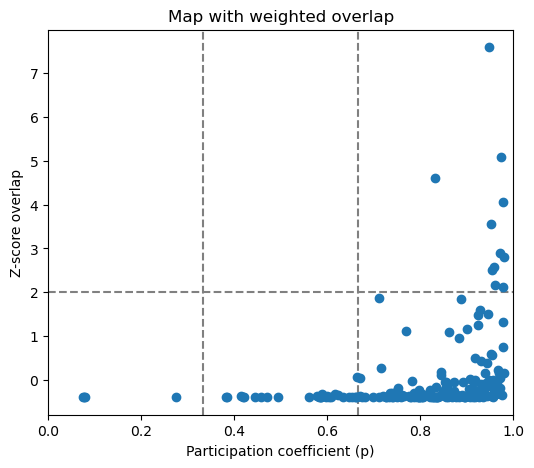

In [135]:
fig_phase,ax = plt.subplots(figsize = (6,5))
ax.axvline(x=1/3, color='grey', linestyle='--',zorder =1)
ax.axvline(x=2/3, color='grey', linestyle='--',zorder = 1)
ax.axhline(y=2, color='grey', linestyle='--',zorder = 1)
ax.scatter(deg_particip.partic_coeff, deg_particip.z_overl,zorder = 2,label= deg_particip.country)
ax.set_xlim (0,1)
ax.set_xlabel('Participation coefficient (p)')
ax.set_title ('Map with weighted overlap')

ax.set_ylabel('Z-score overlap')

# Multilayer- Hubs:
bool_multihub= (deg_particip.partic_coeff>=0.6) & (deg_particip.z_overl>=2)
a = deg_particip.loc[bool_multihub,:]
a

Text(0, 0.5, 'Av.degree')

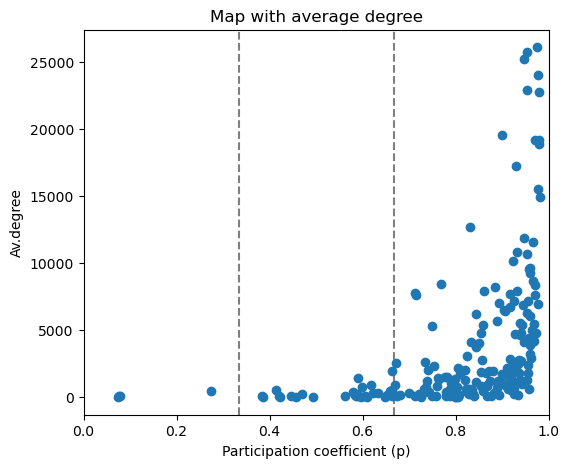

In [136]:
fig_phase,ax = plt.subplots(figsize = (6,5))
ax.axvline(x=1/3, color='grey', linestyle='--',zorder =1)
ax.axvline(x=2/3, color='grey', linestyle='--',zorder = 1)
ax.scatter(deg_particip.partic_coeff, deg_particip.out_deg,zorder = 2)
ax.set_xlim (0,1)
ax.set_xlabel('Participation coefficient (p)')
ax.set_title ('Map with average degree')
ax.set_ylabel('Av.degree')

# Old codes

In [ ]:
''' 
#Old Code

def Edge_overlap_w(data):
    """Calculate the weighted edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """

    overlap_w= data.groupby(['origin_country_ISO']).apply(lambda group : group.value.sum())

    overlap_w= pd.DataFrame(overlap_w.sort_values(ascending=False),columns=['o_i'])
    return overlap_w

def Edge_overlap(data):
    """Calculate the (non-weighted) edge overlap for each 'origin_country_ISO' in a DataFrame.

    In weighted multilayer networks the edge overlap is the sum of all the weights of all out-links in each node.  

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing at least the 'origin_country_ISO' and 'value' columns.

    Returns:
    pd.DataFrame: DataFrame with edge overlap calculated for each 'origin_country_ISO'.
    The output DataFrame has one column named 'overlap' representing the calculated edge overlap weights.

    Example:
    >>> df_result = Edge_overlap_w(input_data)
    """

    overlap= data.groupby(['origin_country_ISO']).apply(lambda group : len(group))

    overlap= pd.DataFrame(overlap.sort_values(ascending=False),columns=['o_i'])
    return overlap
'''

In [ ]:
'''
# Overlap? Check for individual products. 
year= '2019-2021'# 2018
unit = '1000 US$'
products = ['Palm oil','Apples','Cane sugar, non-centrifugal']
key_wanted = [tuple([product, unit]) for product in products]
print(key_wanted[0])
data_g = data.groupby(['item','unit']) 
data_net=data_g.get_group(key_wanted[0]) #
data_net
str_layer=data_net.loc[:,['origin_country_ISO','value']].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False)


test_strength = data.groupby(['item','unit']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False))
test_strength_og = test_strength.reset_index(level=['item','unit','origin_country_ISO'])

strength_all = test_strength_og.groupby(['origin_country_ISO']).apply(lambda group: group.loc[:,['origin_country_ISO','value']].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False))

merged_str = pd.merge(test_strength_og, str_overlap, left_on= 'origin_country_ISO',right_index=True, how='left')

# Layer per layer strength: 
merged_str['contribution'] = (merged_str['value']/merged_str['total_val'])**2

sum_particip = merged_str.groupby(['origin_country_ISO']).apply(lambda group: group.loc[:,'value'].pivot_table(index='origin_country_ISO', aggfunc='sum').sort_values(by = 'value',ascending=False))

sum_test= merged_str.groupby(['origin_country_ISO']).apply(lambda group: group.contribution.sum())
L= len(data.item.unique())
partic_coeff = (L/(L-1))*(1- sum_test)


print(merged_str)

data_g = data.groupby(['item','unit']) 
data_net=data_g.get_group(key_wanted) #

edges_multi_all


overlap= pd.DataFrame(np.zeros([len(country_metadata.ISO), len(country_metadata.ISO)]),
             columns= country_metadata['ISO'], index= country_metadata.ISO)
'''